# Define Functions

In [28]:
import os, json
import matplotlib.pyplot as plt
import numpy as np

def find_json_files(base_dir):
    """Recursively find all JSON files in a directory."""
    json_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

def extract_folder_name(file_path, base_dir):
    """Extract the first folder name relative to the base directory."""
    relative_path = os.path.relpath(file_path, base_dir)
    first_folder = relative_path.split(os.sep)[0]  # Get the first folder in the path
    return first_folder

def read_json(file_path):
    """Read and return the content of a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    losses = data.get("losses", [])
    accuracies = data.get("accuracies", [])
    plasticity_per_task = data.get("plasticity_per_task", [])
    return {
        "accuracies": accuracies,
        "plasticity_per_task": plasticity_per_task,
        "losses": losses
    }

def metrics(json_files, base_dir):
    """Compute the average accuracy and plasticity for each folder."""
    averages = {}
    
    for json_file in json_files:
        folder_name = extract_folder_name(json_file, base_dir)
        data = read_json(json_file)
        accuracies = data.get("accuracies", [])
        plasticity_per_task = data.get("plasticity_per_task", [])
        loss = data.get("losses", [])
        
        # Compute metrics
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0
        avg_plasticity = sum(plasticity_per_task) / len(plasticity_per_task) if plasticity_per_task else 0
        lipschitz = np.max(np.abs(np.diff(loss)))
        forgetting = accuracies[0] - accuracies[-1]
        diff_plasticity = plasticity_per_task[0] - plasticity_per_task[-1]


        averages[folder_name] = {
            "average_accuracy": avg_accuracy,
            "average_plasticity": avg_plasticity,
            "lipschitz_const": lipschitz,
            "forgetting": forgetting,
            "diff_plasticity": diff_plasticity
        }
    
    return averages

def print_averages(averages):
    """Print the average accuracy and plasticity for each folder."""
    print(f"{'Approach':<20}{'Average Accuracy':<20}{'Average Plasticity':<20}{'Lipschitz Constant':<20}{'Forgetting':<20}{'Diff Plasticity':<20}")
    print("-" * 120)
    for approach, metrics in averages.items():
        avg_accuracy = metrics["average_accuracy"]
        avg_plasticity = metrics["average_plasticity"]
        lipschitz_const = metrics["lipschitz_const"]
        forgetting = metrics["forgetting"]
        diff_plasticity = metrics["diff_plasticity"]

        print(f"{approach:<20}{avg_accuracy:<20.4f}{avg_plasticity:<20.4f}{lipschitz_const:<20.4f}{forgetting:<20.4f}{diff_plasticity:<20.4f}")

def plot_aggregated_data(json_files, base_dir, metric):
    """Aggregate and plot loss values from all JSON files in one graph."""

    plt.figure(figsize=(10, 6))
    
    for json_file in json_files:
        folder_name = extract_folder_name(json_file, base_dir)
        data = read_json(json_file)
        values = data.get(metric, [])
        
        if isinstance(values, list) and values:  # Check if accuracies are valid
            plt.plot(values, label=folder_name, linewidth=1)
          
    desired_order = [
    "baseline",
    "weight_norm",
    "grad_norm",
    "ratio_norm",
    "entire_kernel",
    "column_kernel",
    "usgd",
    ]
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = dict(zip(labels, handles))

    # Reorder handles and labels based on the desired order
    ordered_handles = [label_to_handle[label] for label in desired_order if label in label_to_handle]
    ordered_labels = [label for label in desired_order if label in label_to_handle]

    
    plt.xlabel("Tasks")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(ordered_handles, ordered_labels,  title="Approaches", loc="lower left")
    plt.show()

def plot_zoomed_data(json_files, base_dir, metric, num_tasks=200, accuracy_range=(0.0, 1.0), selected_approaches=None):
    """
    Plot a zoomed-in graph for the last num_tasks and focus on a specific accuracy range.
    """
    plt.figure(figsize=(10, 6))
    
    for json_file in json_files:
        folder_name = extract_folder_name(json_file, base_dir)
        if folder_name in selected_approaches: 
            data = read_json(json_file)
            values = data.get(metric, [])
        
            if values and isinstance(values, list): 
                plt.plot(values, label=folder_name, linewidth=1)

    plt.xlabel("Tasks")
    plt.ylabel(metric)
    plt.xlim(len(values) - num_tasks, len(values))  # Focus on the last num_tasks
    plt.ylim(accuracy_range)  # Focus on the specified accuracy range
    plt.grid()
    plt.legend(title="Approaches", loc="lower left")
    plt.show()

# Get results for Accuracy and Forgetting

Approach            Average Accuracy    Average Plasticity  Lipschitz Constant  Forgetting          Diff Plasticity     
------------------------------------------------------------------------------------------------------------------------
column_kernel       0.1614              0.0995              0.2717              -0.1000             -0.0002             
usgd                0.5538              0.4594              0.2820              -0.6076             -0.4892             
grad_norm           0.5427              0.4439              0.2006              -0.6160             -0.4801             
baseline            0.5529              0.4542              0.4732              -0.6204             -0.4950             
weight_norm         0.5462              0.4554              0.1991              -0.5920             -0.4800             
ratio_norm          0.5530              0.4548              0.2515              -0.6400             -0.4929             
entire_kernel       0.1529      

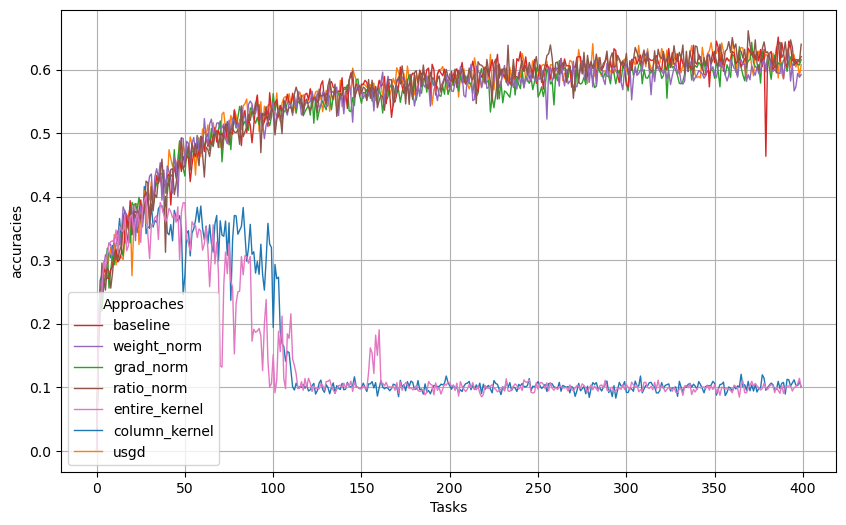

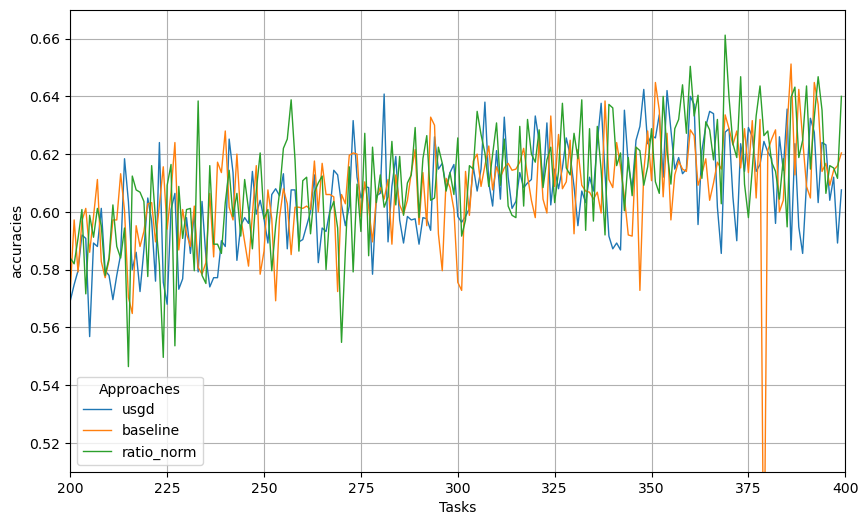

In [30]:
base_dir_cifar = "../logs/label_permuted_cifar10_stats"
json_files = find_json_files(base_dir_cifar)

averages = metrics(json_files, base_dir_cifar)
print_averages(averages)
plot_aggregated_data(json_files, base_dir_cifar, "accuracies")
plot_zoomed_data(json_files, base_dir_cifar, "accuracies", num_tasks=200, accuracy_range=(0.51, 0.67), selected_approaches=["baseline", "ratio_norm", "usgd"])

# Get results for Plasticity and Loss of Plasticity

Approach            Average Accuracy    Average Plasticity  Lipschitz Constant  Forgetting          Diff Plasticity     
------------------------------------------------------------------------------------------------------------------------
column_kernel       0.1481              0.0451              1.2494              -0.1080             0.0083              
usgd                0.6945              0.4552              1.2344              -0.6858             -0.4374             
grad_norm           0.6939              0.4608              0.9892              -0.6516             -0.4393             
baseline            0.6466              0.4186              1.2917              -0.1028             0.0045              
weight_norm         0.5216              0.3277              1.4502              -0.6780             -0.4570             
ratio_norm          0.5778              0.3654              1.3320              -0.1140             0.0047              
entire_kernel       0.1516      

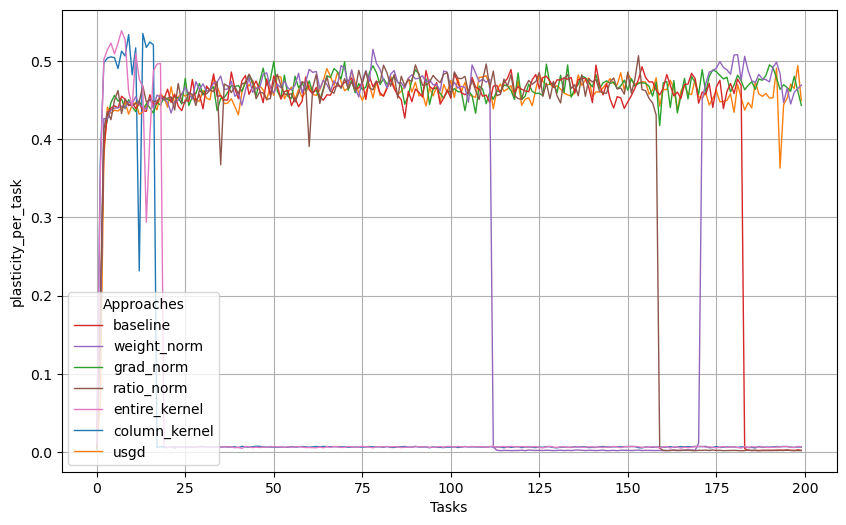

In [31]:
base_dir_mnist= "../logs/input_permuted_mnist_stats"
json_files = find_json_files(base_dir_mnist)

averages = metrics(json_files, base_dir_mnist)
print_averages(averages)
plot_aggregated_data(json_files, base_dir_mnist, "plasticity_per_task")